In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from Dataset.Economy_Dataset import Economy_Dataset
from Dataset.LSTM_Transaction_Train_Dataset import LSTM_Transaction_Train_Dataset
from Dataset.ODE_Transaction_Dataset import ODE_Transaction_Dataset

from Model.LSTM import LSTM
from Model.NODE import NODE
from Model.ODERNN import *
from Model.ODEF import *

from utils import preprocess

c:\Users\USER\Desktop\sci\SCI\코드\Model\ODEF.py:145: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xe (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

transaction_df = pd.read_csv('../데이터/Transaction/transaction_all.csv')
economy_df = pd.read_excel('../데이터/Economy/economy_all.xlsx')

transaction_df, economy_df = preprocess(transaction_df, economy_df, window_size=5)

cuda:0 is available


### 경제 모델

In [16]:
best_val_loss = float('inf') 
for epoch in range(num_epochs + 1):
    model.train()
    for batch_idx, samples in enumerate(economy_train_loader):
        economy_x_train, economy_y_train = samples

        prediction, hidden = model(economy_x_train)
        cost = criterion(prediction, economy_y_train)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, samples in enumerate(economy_val_loader):
            economy_x_val, economy_y_val = samples

            prediction, hidden = model(economy_x_val)
            loss = criterion(prediction, economy_y_val)
            val_loss += loss.item()

    val_loss /= len(economy_val_loader)
    print(f'Epoch {epoch}/{num_epochs}, Training Loss: {cost.item()}, Validation Loss: {val_loss}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '../데이터/Checkpoint/best_rnn_economy_model.pth')

Epoch 0/1, Training Loss: 0.002730900188907981, Validation Loss: 0.3143093644015106
Epoch 1/1, Training Loss: 0.0027428490575402975, Validation Loss: 0.31638226120186774


### LSTM 부동산 돌리기

In [3]:
input_size = 5
hidden_size = 16
output_size = 1

lr = 1e-4
num_epochs = 300

model = LSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size, device=device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [4]:
batch_size = 1

train_dataset = LSTM_Transaction_Train_Dataset(transaction_df[transaction_df['계약년월']//100 != 2022])
train_loader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = LSTM_Transaction_Train_Dataset(transaction_df[transaction_df['계약년월']//100 == 2022])
val_loader = DataLoader(val_dataset, batch_size=batch_size)

for x,y in train_loader:
      print("X 크기 : {}".format(x.shape))
      print("Y 크기 : {}".format(y.shape))
      break

c:\Users\USER\Desktop\sci\SCI\코드\Dataset\LSTM_Transaction_Train_Dataset.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['계약년월'] = pd.to_datetime(df['계약년월'].astype(str), format='%Y%m')
c:\Users\USER\Desktop\sci\SCI\코드\Dataset\LSTM_Transaction_Train_Dataset.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['계약년월'] = pd.to_datetime(df['계약년월'].astype(str), format='%Y%m')


X 크기 : torch.Size([1, 5])
Y 크기 : torch.Size([1, 1])


In [5]:
train_losses = []

for epoch in range(num_epochs+1):
    model.train()
    total_train_loss = 0.0
    
    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)

        prediction, hidden = model(x_train)
        cost = criterion(prediction, y_train)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        total_train_loss += cost.item()
        
    total_train_loss /= len(train_loader)
    train_losses.append(total_train_loss)
    
    print(f'Epoch {epoch}/{num_epochs}, Training Loss: {total_train_loss}')
    
    save_path = f"../데이터/Checkpoint/lstm_transaction_train_model_epoch_{epoch}.pth"
    torch.save(model.state_dict(), save_path)

Epoch 0/300, Training Loss: 0.8823492953859482
Epoch 1/300, Training Loss: 0.17963628630959538
Epoch 2/300, Training Loss: 0.16968892930227597
Epoch 3/300, Training Loss: 0.16612966451157676
Epoch 4/300, Training Loss: 0.16316348854310248
Epoch 5/300, Training Loss: 0.1621046671194399
Epoch 6/300, Training Loss: 0.15932035175085682
Epoch 7/300, Training Loss: 0.16134757294320795
Epoch 8/300, Training Loss: 0.16035716731819313
Epoch 9/300, Training Loss: 0.160125290477425
Epoch 10/300, Training Loss: 0.15791949076810408
Epoch 11/300, Training Loss: 0.15401207396001282
Epoch 12/300, Training Loss: 0.1520675809292226
Epoch 13/300, Training Loss: 0.15159820044819347
Epoch 14/300, Training Loss: 0.15249401557658646
Epoch 15/300, Training Loss: 0.15201810566741072
Epoch 16/300, Training Loss: 0.15145841510364189
Epoch 17/300, Training Loss: 0.15133124272583248
Epoch 18/300, Training Loss: 0.15053684409646303
Epoch 19/300, Training Loss: 0.14819120832728475
Epoch 20/300, Training Loss: 0.1480

In [6]:
losses_df = pd.DataFrame({
    'train_losses': train_losses,
    # 'val_losses': val_losses
})

losses_df.to_excel('lstm_transaction_train_losses.xlsx', index=False)

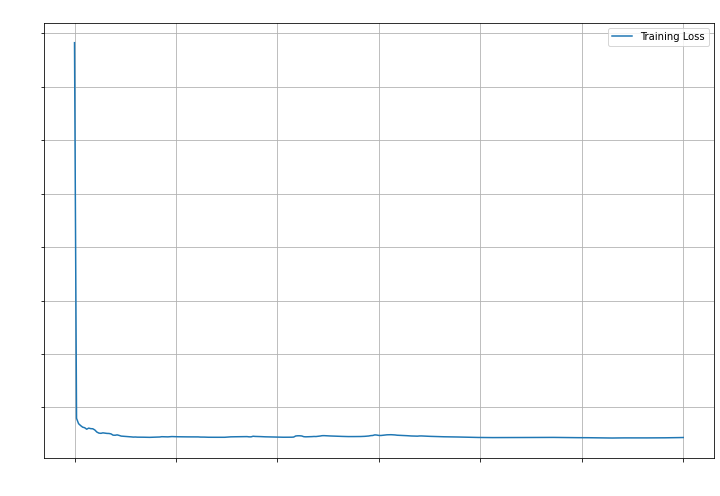

In [10]:
losses_df = pd.read_excel('../데이터/Loss/lstm_transaction_train_losses.xlsx')

# plt.figure(figsize=(12, 8)) 
# plt.plot(losses_df['train_losses'], label='Training Loss')
# plt.plot(losses_df['val_losses'], label='Validation Loss')
# plt.title('Training and Validation Losses', color='white')
# plt.xlabel('Epoch', color='white')
# plt.ylabel('Loss', color='white')
# plt.xticks(color='white')
# plt.yticks(color='white')
# plt.legend()
# plt.grid(True)
# plt.show()

plt.figure(figsize=(12, 8)) 
plt.plot(losses_df['train_losses'], label='Training Loss')
plt.title('Training Losses', color='white')
plt.xlabel('Epoch', color='white')
plt.ylabel('Loss', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.legend()
plt.grid(True)
plt.show()

# plt.figure(figsize=(12, 8)) 
# plt.plot(losses_df['val_losses'], label='Validation Loss')
# plt.title('Validation Losses', color='white')
# plt.xlabel('Epoch', color='white')
# plt.ylabel('Loss', color='white')
# plt.xticks(color='white')
# plt.yticks(color='white')
# plt.legend()
# plt.grid(True)
# plt.show()

### NODE 부동산 돌리기

In [3]:
# 데이터 다운로드
batch_size = 1
transaction_df = pd.read_excel('../데이터/Transaction/transaction_final.xlsx', index_col=0)

train_dataset = ODE_Transaction_Dataset(transaction_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size)



NameError: name 'transaction_df' is not defined

In [4]:
for x,y,z,w in train_loader:
      print("X 크기 : {}".format(x.shape))
      print("Y 크기 : {}".format(y.shape))
      print("Z 크기 : {}".format(z.shape))
      print("W 크기 : {}".format(w.shape))
      break

X 크기 : torch.Size([2, 5])
Y 크기 : torch.Size([2, 5])
Z 크기 : torch.Size([2, 1])
W 크기 : torch.Size([2, 1])


In [5]:
for x,y,z,w in train_loader:
      print("X 크기 : {}".format(x.dtype))
      print("Y 크기 : {}".format(y.dtype))
      print("Z 크기 : {}".format(z.dtype))
      print("W 크기 : {}".format(w.dtype))
      break

X 크기 : torch.float32
Y 크기 : torch.float32
Z 크기 : torch.float32
W 크기 : torch.float32


In [6]:
# 데이터 & 모델에 device 붙임!!!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # 윈도우 gpu
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu') # 맥 gpu
print(f'{device} is available')

model = NODE(output_dim=1,hidden_dim=256,latent_dim=64).to(device)

print('작동하는지 실험')
basic_data = torch.rand((5,2,1)).to(device)  # window_size, batch_size, 1
time = torch.FloatTensor([[1,2,3,6,10,12],[1,3,5,8,10,12]]).reshape(6,2,1).to(device) # window_size, batch_size, 1
data = model(basic_data,time)
print(data)
print(data[0].shape)

cpu is available
작동하는지 실험
(tensor([[[0.3200],
         [0.3020]],

        [[0.3165],
         [0.3053]],

        [[0.3074],
         [0.3091]],

        [[0.3381],
         [0.3102]],

        [[0.3129],
         [0.3069]]], grad_fn=<SliceBackward0>), tensor([[[-1.9246,  0.9916,  0.5816,  ..., -0.0953, -0.4212,  0.2555],
         [-0.3911,  0.1918,  0.4691,  ..., -0.1469, -0.4416,  0.2056]],

        [[-2.3361,  0.9280,  0.5030,  ..., -0.3589, -0.1182, -0.2516],
         [-0.4929,  0.1927, -0.0292,  ...,  0.3396, -0.2586, -0.0658]],

        [[-3.3343,  0.8663,  0.3372,  ..., -1.4191,  0.6670, -1.6950],
         [-0.4960,  0.2321, -0.2474,  ...,  0.5994, -0.1838, -0.2525]],

        [[ 0.8072,  1.3306,  1.7080,  ..., -0.8884, -1.7589,  2.7519],
         [ 0.6183,  0.7583,  1.9381,  ..., -1.3055, -0.8485,  0.8296]],

        [[-2.7293,  0.8898,  0.4417,  ..., -0.7159,  0.1923, -0.7784],
         [-0.5078,  0.2105, -0.1448,  ...,  0.4671, -0.2156, -0.1514]],

        [[ 1.2445,  1.3671

In [7]:
window_size = 5
noise_std = 0.02
optim = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=0.001)

num_epochs=50

In [8]:
best_train_loss = float('inf') 
for epoch in range(num_epochs + 1):
    print('epoch : ',epoch)
    losses = []
    model.train()
    for batch_idx, samples in enumerate(train_loader):
        tran_x, time_x, tran_y, time_y = samples
        
        t = torch.cat((time_x,time_y),dim=1)  
        tran_x = tran_x.transpose(0,1).unsqueeze(2).to(device)
        t = t.transpose(0,1).unsqueeze(2).to(device)
        
        x_p, _, z, z_mean, z_log_var, pred = model(tran_x, t)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), -1)
        loss = 0.5 * ((tran_x-x_p)**2).sum(-1).sum(0) / noise_std**2 + kl_loss
        loss = torch.mean(loss)
        loss /= window_size
        optim.zero_grad()   ############### 여기서 second 오류가 나는지 확인!!!!
        loss.backward()
        optim.step()
        losses.append(loss.item())
        
        if loss < best_train_loss:
            best_train_loss = loss
            torch.save(model.state_dict(), "../데이터/checkpoint/best_ODE_transaction_model.pth")
        
        print('loss : {}, best loss : {}'.format(loss, best_train_loss))
    print('-----------------------------------------------------')

epoch :  0
loss : 11219012608.0, best loss : 11219012608.0
loss : 13275686912.0, best loss : 11219012608.0
loss : 13226204160.0, best loss : 11219012608.0
loss : 11485132800.0, best loss : 11219012608.0
loss : 8940823552.0, best loss : 8940823552.0
loss : 7942053888.0, best loss : 7942053888.0
loss : 8093862912.0, best loss : 7942053888.0
loss : 9578081280.0, best loss : 7942053888.0
loss : 11440328704.0, best loss : 7942053888.0
loss : 13386883072.0, best loss : 7942053888.0
loss : 15193017344.0, best loss : 7942053888.0
loss : 1.5491499810317402e+19, best loss : 7942053888.0
loss : nan, best loss : 7942053888.0
loss : nan, best loss : 7942053888.0
loss : nan, best loss : 7942053888.0
loss : nan, best loss : 7942053888.0
loss : nan, best loss : 7942053888.0
loss : nan, best loss : 7942053888.0
loss : nan, best loss : 7942053888.0
loss : nan, best loss : 7942053888.0
loss : nan, best loss : 7942053888.0
loss : nan, best loss : 7942053888.0
loss : nan, best loss : 7942053888.0
loss : na

KeyboardInterrupt: 

### ODERNN 부동산 돌리기

In [23]:
lr = 1e-4
num_epochs = 300

model = ODE_RNN(256,64,1,200,200,device).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [20]:
batch_size = 1

train_dataset = ODE_Transaction_Dataset(transaction_df[transaction_df['계약년월']//100 != 2022])
train_loader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = ODE_Transaction_Dataset(transaction_df[transaction_df['계약년월']//100 == 2022])
val_loader = DataLoader(val_dataset, batch_size=batch_size)

c:\Users\USER\Desktop\sci\SCI\코드\Dataset\ODE_Transaction_Dataset.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['계약년월'] = pd.to_datetime(data['계약년월'].astype(str), format='%Y%m')
c:\Users\USER\Desktop\sci\SCI\코드\Dataset\ODE_Transaction_Dataset.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['계약년월'] = pd.to_datetime(data['계약년월'].astype(str), format='%Y%m')


In [21]:
for x,y,z,w in train_loader:
      print("X 크기 : {}".format(x.shape))
      print("Y 크기 : {}".format(y.shape))
      print("Z 크기 : {}".format(z.shape))
      print("W 크기 : {}".format(w.shape))
      break

X 크기 : torch.Size([1, 5])
Y 크기 : torch.Size([1, 5])
Z 크기 : torch.Size([1, 1])
W 크기 : torch.Size([1, 1])


In [22]:
print('작동하는지 실험')
t = torch.FloatTensor([[1.,2.,3.,5.,9.,12.]]).to(device)
data = torch.FloatTensor([[123,126,266,279,300]]).to(device)

out = model(data,t)
print(out[0])

작동하는지 실험
tensor([[0., 0., 0., 0., 0., 0.]], device='cuda:0', grad_fn=<CopySlices>)


#### 학습하기

In [10]:
# # 학습 되는지 파악하기!!!!!!!

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(f'{device} is available')

# model = ODE_RNN(256,64,1,200,200,device).to(device)

# print('작동하는지 실험')
# t = torch.FloatTensor([[1.,2.,3.,5.,9.,12.]]).to(device)
# data = torch.FloatTensor([[123,126,266,279,300]]).to(device)

# out, _ = model(data,t)

# loss = criterion(out[0][:5], torch.FloatTensor([2,5,6,7,8]))

# loss.backward()

# for name,param in model.named_parameters():
#     if param.requires_grad:
#         print(name,param.grad)

In [24]:
train_losses = []
val_losses = []

best_val_loss = float('inf')

for epoch in range(num_epochs+1):
    model.train()
    total_train_loss = 0.0

    for batch_idx, (tran_x, time_x, tran_y, time_y) in enumerate(train_loader):
        tran_x, time_x, tran_y, time_y = tran_x.to(device), time_x.to(device), tran_y.to(device), time_y.to(device)
        time_f = torch.cat([time_x,time_y], axis=1)

        prediction, hidden = model(tran_x, time_f)
        cost = criterion(prediction[0][:5], tran_x[0])

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        total_train_loss += cost.item()
    
    total_train_loss /= len(train_loader)
    train_losses.append(total_train_loss)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (tran_x, time_x, tran_y, time_y) in enumerate(val_loader):
            tran_x, time_x, tran_y, time_y = tran_x.to(device), time_x.to(device), tran_y.to(device), time_y.to(device)
            time_f = torch.cat([time_x,time_y], axis=1)
            
            prediction, hidden = model(tran_x, time_f)
            loss = criterion(prediction, y_val)

            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch}/{num_epochs}, LR: {lr}, Training Loss: {total_train_loss}, Validation Loss: {val_loss}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_path = f"../데이터/Checkpoint/best_ode_transaction_model(300 epoch_0.0001 lr).pth"
        torch.save(model.state_dict(), save_path)

save_path = f"../데이터/Checkpoint/recent_ode_transaction_model(300 epoch_0.0001 lr).pth"
torch.save(model.state_dict(), save_path)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0/300, LR: 0.0001, Training Loss: 42.8354185386184, Validation Loss: 29.2708740234375
Epoch 1/300, LR: 0.0001, Training Loss: 42.345011187520115, Validation Loss: 29.2708740234375
Epoch 2/300, LR: 0.0001, Training Loss: 42.345011187520115, Validation Loss: 29.2708740234375


In [2]:
for lr in [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2]:
    model = ODE_RNN(256,64,1,200,200,device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_train_loss = float('inf') 
    for epoch in range(num_epochs + 1):
        losses = []
        model.train()
        
        for batch_idx, samples in enumerate(train_loader):
            tran_x, time_x, tran_y, time_y = samples
            tran_x, time_x, tran_y, time_y = tran_x.to(device), time_x.to(device), tran_y.to(device), time_y.to(device)
            time_f = torch.cat([time_x,time_y],axis=1)
            prediction, hidden = model(tran_x,time_f)
            
            optimizer.zero_grad()
            cost = criterion(prediction[0][:5], tran_x[0])
            cost.backward()
            optimizer.step()
        # for name,param in model.named_parameters():
            # if param.requires_grad:
            #     print(name,param.grad)
            #     break
        print(f'Learning_rate: {lr}, Epoch {epoch}/{num_epochs}, Training Loss: {cost.item()}')
        # model.eval()
        # val_loss = 0.0
        # with torch.no_grad():
        #     for batch_idx, samples in enumerate(transaction_val_loader):
        #         x_val, y_val = samples

        #         prediction, hidden = model(x_val)
        #         loss = criterion(prediction, y_val)
        #         val_loss += loss.item()

        # val_loss /= len(transaction_val_loader)
        # print(f'Epoch {epoch}/{num_epochs}, Training Loss: {cost.item()}, Validation Loss: {val_loss}')
        
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     torch.save(model.state_dict(), '../데이터/Checkpoint/best_rnn_transaction_model.pth')

c:\Users\USER\Desktop\sci\SCI\코드\Dataset\ODE_Transaction_Dataset.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['계약년월'] = pd.to_datetime(data['계약년월'].astype(str), format='%Y%m')


Learning_rate: 1e-07, Epoch 0/5, Training Loss: 422.15655517578125
Learning_rate: 1e-07, Epoch 1/5, Training Loss: 422.1231384277344
Learning_rate: 1e-07, Epoch 2/5, Training Loss: 422.0897521972656
Learning_rate: 1e-07, Epoch 3/5, Training Loss: 422.0563659667969
Learning_rate: 1e-07, Epoch 4/5, Training Loss: 422.02294921875
Learning_rate: 1e-07, Epoch 5/5, Training Loss: 421.989501953125


c:\Users\USER\Desktop\sci\SCI\코드\Dataset\ODE_Transaction_Dataset.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['계약년월'] = pd.to_datetime(data['계약년월'].astype(str), format='%Y%m')


Learning_rate: 1e-06, Epoch 0/5, Training Loss: 421.86181640625
Learning_rate: 1e-06, Epoch 1/5, Training Loss: 421.5279235839844
Learning_rate: 1e-06, Epoch 2/5, Training Loss: 421.1943359375
Learning_rate: 1e-06, Epoch 3/5, Training Loss: 420.86114501953125
Learning_rate: 1e-06, Epoch 4/5, Training Loss: 420.5282287597656
Learning_rate: 1e-06, Epoch 5/5, Training Loss: 420.1957092285156


c:\Users\USER\Desktop\sci\SCI\코드\Dataset\ODE_Transaction_Dataset.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['계약년월'] = pd.to_datetime(data['계약년월'].astype(str), format='%Y%m')


Learning_rate: 1e-05, Epoch 0/5, Training Loss: 418.931640625
Learning_rate: 1e-05, Epoch 1/5, Training Loss: 415.6735534667969
Learning_rate: 1e-05, Epoch 2/5, Training Loss: 412.51904296875
Learning_rate: 1e-05, Epoch 3/5, Training Loss: 409.501953125
Learning_rate: 1e-05, Epoch 4/5, Training Loss: 406.6498718261719
Learning_rate: 1e-05, Epoch 5/5, Training Loss: 403.9827880859375


c:\Users\USER\Desktop\sci\SCI\코드\Dataset\ODE_Transaction_Dataset.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['계약년월'] = pd.to_datetime(data['계약년월'].astype(str), format='%Y%m')


Learning_rate: 0.0001, Epoch 0/5, Training Loss: 396.4898376464844
Learning_rate: 0.0001, Epoch 1/5, Training Loss: 386.22821044921875
Learning_rate: 0.0001, Epoch 2/5, Training Loss: 383.25341796875
Learning_rate: 0.0001, Epoch 3/5, Training Loss: 382.4549865722656
Learning_rate: 0.0001, Epoch 4/5, Training Loss: 382.2449645996094
Learning_rate: 0.0001, Epoch 5/5, Training Loss: 382.1899108886719


c:\Users\USER\Desktop\sci\SCI\코드\Dataset\ODE_Transaction_Dataset.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['계약년월'] = pd.to_datetime(data['계약년월'].astype(str), format='%Y%m')


Learning_rate: 0.001, Epoch 0/5, Training Loss: 382.3034362792969
Learning_rate: 0.001, Epoch 1/5, Training Loss: 382.17236328125
Learning_rate: 0.001, Epoch 2/5, Training Loss: 382.1704406738281
Learning_rate: 0.001, Epoch 3/5, Training Loss: 382.1704406738281
Learning_rate: 0.001, Epoch 4/5, Training Loss: 382.1704406738281
Learning_rate: 0.001, Epoch 5/5, Training Loss: 382.1704406738281


c:\Users\USER\Desktop\sci\SCI\코드\Dataset\ODE_Transaction_Dataset.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['계약년월'] = pd.to_datetime(data['계약년월'].astype(str), format='%Y%m')


Learning_rate: 0.01, Epoch 0/5, Training Loss: 382.17230224609375
Learning_rate: 0.01, Epoch 1/5, Training Loss: 382.1704406738281
Learning_rate: 0.01, Epoch 2/5, Training Loss: 382.1704406738281
Learning_rate: 0.01, Epoch 3/5, Training Loss: 382.1704406738281
Learning_rate: 0.01, Epoch 4/5, Training Loss: 382.1704406738281
Learning_rate: 0.01, Epoch 5/5, Training Loss: 382.1704406738281
